In [ ]:
!rm -rf ./ML4CV_Assignment
!git clone https://github.com/liuktc/ML4CV_Assignment.git
!pip install pytorch_metric_learning wandb

# TO-DO

- Rewrite model-evaluation section

In [1]:
%load_ext autoreload
%autoreload 2

import os
import zipfile
from io import BytesIO
from pprint import pprint

import matplotlib.pyplot as plt
import requests
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

from dataset import PadToMultipleOf16, StreetHazardDataset
from metrics import compute_metrics
from model_new import (
    AbstractOutlierDetector,
    EnergyBasedOutlierDetector,
    GMMOutlierDetector,
)
from plot import plot_examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

KAGGLE = False
NUM_CLASSES = 13
SEED = 42
ORIGINAL_IMAGE_SIZE = (720, 1280)

# Seed everything
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set_theme(style="whitegrid", context="paper", font_scale=1.8)
plt.rcParams['font.family'] = ['cmr10']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

c:\Users\Luca\Desktop\MagistraleAI\2nd_year\Machine Learning for Computer Vision\Assignment\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SCALE_FACTOR = 1
PREPROCESS = "resize"
BATCH_SIZE = 1
NUM_WORKERS = 2
DINO_REPO = "./dinov3"
CNN_OUT_DIM = 16
EMBEDDING_DIM = 256
# If this URL is expired, get the new one from
# https://ai.meta.com/resources/models-and-libraries/dinov3-downloads/
DINO_URL =  r"https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiMWY3cDI4emZrdGZ5NmI2MWZmcjBuemR2IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTc3NzA5NTd9fX1dfQ__&Signature=vKWh9x7KeEwBiHOBalTbkGVwAXE-Nko6w2myuXyqY66Bk9Be%7EVV5qrCuyFxqc%7E4ImtRCg%7EUDNZ2zCWnjI7Gsmic%7E-s-sdmp6roixgPpstDmmMJAXtN-xCpQsiZLCDwhfSLXVcUq-9dvjFoYtkk%7EDyUaI%7EDZorg7gcQl-tuMkB725z5HDdzmrvjJUkO9Vp%7EIG3IONee8%7E7JEE3U3Bq9Ms6NFRu1LEiET%7EW2lzmxVsnCcwRZfLPeq%7Erct1M%7EvZrp0DlHCfdWudxS5FTFzbkW0l9V6FegzHSStd7o-xPv-%7EIRiYpfVRquUvqtdwgKR40T-bLZ38-REPZ%7EceB%7EtpakNFrg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1866286203927616"

In [3]:
WEIGHTS_LINK = "https://psitransfer.unogatto.ovh/files/1e19d57dc008++cc8b3359-b129-42da-8a6c-82f1e556ac48"
# Download the weights from the link above and extract them in the current directory
if not os.path.exists("./weights"):
    request = requests.get(WEIGHTS_LINK)
    zip_file = zipfile.ZipFile(BytesIO(request.content))
    zip_file.extractall(".")

In [4]:
image_size = PadToMultipleOf16().convert_dims(
    (ORIGINAL_IMAGE_SIZE[0] * SCALE_FACTOR, ORIGINAL_IMAGE_SIZE[1] * SCALE_FACTOR)
)

if KAGGLE:
    annotations_train_file = "/kaggle/input/streethazards-train/train/train.odgt"
    annotation_val_file = "/kaggle/input/streethazards-train/train/validation.odgt"
    annotation_test_file = "/kaggle/input/streethazards-test/test/test.odgt"
    img_dir = "/kaggle/input/streethazards-train/train/"
    img_dir_test = "/kaggle/input/streethazards-test/test/"
else:
    annotations_train_file = "./data/train/train.odgt"
    annotation_val_file = "./data/train/validation.odgt"
    annotation_test_file = "./data/test/test.odgt"
    img_dir = "./data/train/"
    img_dir_test = "./data/test/"

if PREPROCESS == "resize":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(image_size, interpolation=InterpolationMode.BICUBIC),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.Resize(image_size, interpolation=InterpolationMode.NEAREST),
        ]
    )
elif PREPROCESS == "crop":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomCrop(image_size),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.RandomCrop(image_size),
        ]
    )

dataset_train = StreetHazardDataset(
    annotations_train_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dataset_test = StreetHazardDataset(
    annotation_test_file,
    img_dir_test,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

# Take only a subset of the training set
dataset_train = Subset(dataset_train, list(torch.randperm(len(dataset_train))[:50]))

dl_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False,
)
dl_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False
)

# Data Exploration

The dataset used for this assignment is the [Street Hazards](https://arxiv.org/abs/1911.11132) dataset, which is a synthetic dataset designed for anomaly detection in street scenes. The dataset contains images of street scenes with various types of anomalies, such as unusual objects or unexpected events.

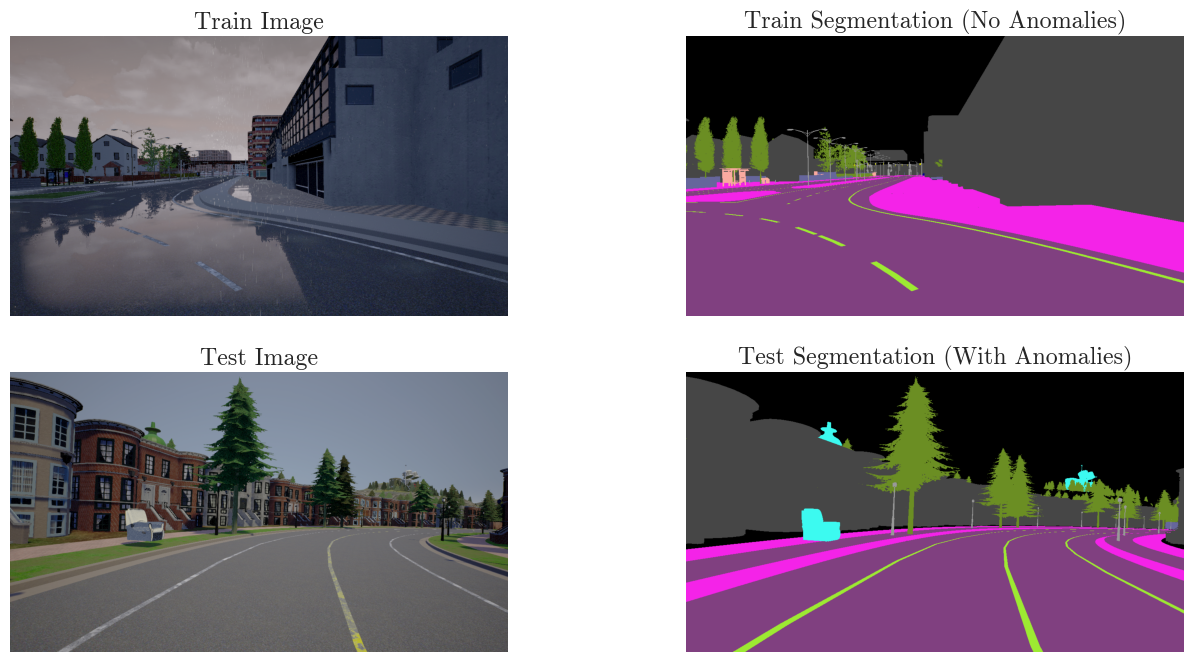

In [5]:
import matplotlib.pyplot as plt

from plot import color, de_normalize

INDEX = 2
train_image, train_segmentation = dataset_train[INDEX]
test_image, test_segmentation = dataset_test[INDEX]

plt.figure(figsize=(16,8))
plt.subplot(2,2, 1)
plt.title("Train Image")
plt.imshow(de_normalize(train_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 2)
plt.title("Train Segmentation (No Anomalies)")
plt.imshow(color(train_segmentation))
plt.axis('off')
plt.subplot(2,2, 3)
plt.title("Test Image")
plt.imshow(de_normalize(test_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 4)
plt.title("Test Segmentation (With Anomalies)")
plt.imshow(color(test_segmentation))
plt.axis('off')
plt.show()

# Open-World Semantic Segmentation Approach

The task of this assignment is to perform open-world semantic segmentation, which involves segmenting images into known classes while also identifying and segmenting unknown or anomalous objects (as a new unseen class).
The particular challenge of this task is that the model does not have access to any examples of the unknown classes during training, and must rely on its ability to generalize from the known classes to identify and segment the unknown classes.
The proposed approach is the following:
- Use a foundation model (DINOv3) to extract features from the images.
- Train a segmentation head using two losses:
  - Cross-entropy loss for the known classes.
  - A metric learning loss (e.g., contrastive loss) to encourage the model to learn a feature space where known classes are well-separated.
- During inference, use the logits from the segmentation head to identify unknown classes by thresholding the maximum softmax probability.

# Model

### Full

![ML4CV Architecture Diagram](https://raw.githubusercontent.com/liuktc/ML4CV_Assignment/refs/heads/main/ML4CV%20Diagram.svg)

The model consists of the following components:
1. **Frozen backbone**: A pre-trained [DINOv3](https://github.com/facebookresearch/dinov3) model is used as a feature extractor. The model is frozen during training to leverage the rich feature representations learned from large-scale data.
2. **Small CNN**: A small CNN takes the input image and extracts low level, but high-resolution features. These features are then summed with the features from the DINOv3 backbone to provide both high-level and low-level information to the segmentation head.
3. **Segmentation head**: A simple $1 \times 1$ convolutional layer is used as the segmentation head. This layer takes the combined features from the backbone and the small CNN and produces logits for each class (excluding the unknown class).
4. **Anomaly Detector**: Use [energy based](https://arxiv.org/abs/2010.03759) method to identify anomalies. The energy score is computed from the logits produced by the segmentation head.

This model is denoted in the code as `full`.


### Alternative (without small CNN)

An alternative model without the small CNN (denoted `upsampling`) is also implemented to evaluate the impact of low-level features on the performance.

# Training

To train the model, the following loss is used:

$$ \mathcal{L} = \lambda_{1} \cdot \mathcal{L}_{CE} + \lambda_{2} \cdot \mathcal{L}_{\texttt{metric}}$$

where:
- $\mathcal{L}_{CE}$ is the cross-entropy loss for the known classes. This loss encourages the model to correctly classify pixels belonging to known classes. Used to perform the classical semantic segmentation task.
- $\mathcal{L}_{\texttt{metric}}$ is a metric learning loss (e.g., contrastive loss) that encourages the model to learn a feature space where known classes are well-separated. The following choice for $\mathcal{L}_{\texttt{metric}}$ are tested:
  - [**Proxy-Anchor Loss**](https://arxiv.org/abs/2003.13911): This loss introduces a set of learnable **proxies** (one per class) that serve as anchors. Each proxy attracts embeddings of its own class while repelling embeddings of other classes. Unlike Proxy-NCA, Proxy-Anchor aggregates **all positives and negatives** per proxy with a log-sum-exp, which emphasizes harder samples and stabilizes optimization.
  - **Triplet Margin Loss**: Mines many triplets (anchor, positive, negative) within a batch and tries to ensure that the distance between the anchor and positive is smaller than the distance between the anchor and negative by a margin.
  - [**NT-Xent Loss**](arxiv.org/abs/1807.03748): A contrastive loss that encourages similar samples to be close in the feature space while pushing dissimilar samples apart. It uses a temperature parameter to scale the logits before applying the softmax function.
- $\lambda_1, \lambda_2$ are hyperparameters that control the relative importance of the two loss components.

All the models has been trained using Adam as an optimizer, with a constant learning rate of $10^{-4}$ for $10$ epochs. All the training history can be inspected at the following Weights & Biases project: [ML4CV_Assignment](https://wandb.ai/luca24ever_unibo/ML4CV_Assignment).

# Anomaly Detection

To detect anomalies using the trained model, the following approaches has been tested:
- **Energy Based**: This method uses the maximum softmax probability from the segmentation head as a confidence score. The lower the confidence, the more likely the pixel is to be an anomaly. Note that this approach works in the space of the logits, so after the segmentation head.
- **Guassian Mixture Model (GMM)**: This method fits a GMM to the feature embeddings of the known classes. During inference, the likelihood of each pixel's embedding under the GMM is computed, and pixels with low likelihoods are considered anomalies. This approach works in the feature space, so before the segmentation head.

# Model Evaluation

Tried different losses for the metric learning component:
- Proxy-NCA loss
- NT-Xent loss
- Triplet loss
- No metric learning loss (only cross-entropy loss)

Tried 2 different models:
- Model with small CNN (denoted `model`)
- Model without small CNN (denoted `model_upsampling`)

In [6]:
from model_new import build_model

MODELS = {
    "ntxent_full":{
        "type": "full",
        "dino_url" : DINO_URL,
        "cnn_out_dim": CNN_OUT_DIM,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/ntxent_full.pth"
    },
    "proxy_full":{
        "type": "full",
        "dino_url" : DINO_URL,
        "cnn_out_dim": CNN_OUT_DIM,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/proxy_full.pth"
    },
    "triplet_full":{
        "type": "full",
        "dino_url" : DINO_URL,
        "cnn_out_dim": CNN_OUT_DIM,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/triplet_full.pth"
    },
    "no_metric_full": {
        "type": "full",
        "dino_url" : DINO_URL,
        "cnn_out_dim": CNN_OUT_DIM,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/onlyCE_full.pth"
    },
    "ntxent_upsampling": {
        "type": "dino_upsample",
        "dino_url" : DINO_URL,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/ntxent_upsampling.pth"
    },
    "proxy_upsampling": {
        "type": "dino_upsample",
        "dino_url" : DINO_URL,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/proxy_upsampling.pth"
    },
    "triplet_upsampling": {
        "type": "dino_upsample",
        "dino_url" : DINO_URL,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/triplet_upsampling.pth"
    },
    "no_metric_upsampling": {
        "type": "dino_upsample",
        "dino_url" : DINO_URL,
        "device": device,
        "embedding_dim": EMBEDDING_DIM,
        "weights": "./weights/onlyCE_upsampling.pth"
    }
}      

In [7]:
DETECTORS = {
    "Energy_OD": (EnergyBasedOutlierDetector, {
        "temperature": 1,
        "device": device
    }),
    "GMM_OD": (GMMOutlierDetector, {
        "num_classes": NUM_CLASSES,
        "n_components": 2,
        "step_batch": 2,
        "covariance_type": "diag",
        "device": device
    }),
}

## Computing test metrics

In [9]:
results = {}

if os.path.exists("./results.pt"):
    results = torch.load("./results.pt")
    print("Loaded existing results:")

with torch.no_grad():
    for model_name, model_args in tqdm(MODELS.items(), desc="Evaluating models: "):
        model = None
        for detector_name, (detector_class, detector_args) in DETECTORS.items():
            if f"{model_name}_{detector_name}" in results:
                print(f"Skipping {model_name} with {detector_name}, already computed.")
                continue
            # Instantiate model
            model = build_model(**model_args)

            # Instantiate detector
            detector_args["model"] = model
            detector: AbstractOutlierDetector = detector_class(**detector_args).to(device)
            if detector.needs_fit:
                detector.fit(dl_train)
            
            # Run testing and save results
            metrics = compute_metrics(model, detector, dataset_test, device, model_name, detector_name)
            results[f"{model_name}_{detector_name}"] = metrics

            # Save intermediate results
            torch.save(results, "./results.pt")

            # Remove detector from GPU to save memory
            del detector
            torch.cuda.empty_cache()
        
        # Remove model from GPU to save memory
        del model
        torch.cuda.empty_cache()

Loaded existing results:


Evaluating models: 100%|██████████| 8/8 [00:00<?, ?it/s]

Skipping ntxent_full with Energy_OD, already computed.
Skipping ntxent_full with GMM_OD, already computed.
Skipping proxy_full with Energy_OD, already computed.
Skipping proxy_full with GMM_OD, already computed.
Skipping triplet_full with Energy_OD, already computed.
Skipping triplet_full with GMM_OD, already computed.
Skipping no_metric_full with Energy_OD, already computed.
Skipping no_metric_full with GMM_OD, already computed.
Skipping ntxent_upsampling with Energy_OD, already computed.
Skipping ntxent_upsampling with GMM_OD, already computed.
Skipping proxy_upsampling with Energy_OD, already computed.
Skipping proxy_upsampling with GMM_OD, already computed.
Skipping triplet_upsampling with Energy_OD, already computed.
Skipping triplet_upsampling with GMM_OD, already computed.
Skipping no_metric_upsampling with Energy_OD, already computed.
Skipping no_metric_upsampling with GMM_OD, already computed.


In [10]:
pprint(results)

{'no_metric_full_Energy_OD': {'aupr': {'mean': 0.1371361083766654,
                                       'std': 0.14780664443969727},
                              'miou': {'mean': 0.4934365550875664,
                                       'std': 0.06160065159201622}},
 'no_metric_full_GMM_OD': {'aupr': {'mean': 0.010303666818851222,
                                    'std': 0.013686525635421276},
                           'miou': {'mean': 0.4934365550875664,
                                    'std': 0.06160065159201622}},
 'no_metric_upsampling_Energy_OD': {'aupr': {'mean': 0.09129501607706576,
                                             'std': 0.08819933980703354},
                                    'miou': {'mean': 0.4320181171298027,
                                             'std': 0.05845845118165016}},
 'no_metric_upsampling_GMM_OD': {'aupr': {'mean': 0.010303666818851222,
                                          'std': 0.013686525635421276},
                           

# Quantitative Results

In the following tables, the syntax $a \pm b$ means that $a$ is the mean and $b$ is the standard deviation.

## Segmentation Results


|                         | Model Full  | Model only DinoV3 |
| :---------------------: | :---------: | :---------------: |
| Triplet Loss            | **mIoU** $ = 0 \pm 0$ | **mIoU** $ = 0 \pm 0$ |
| NT-Xent Loss            | **mIoU** $ = 0 \pm 0$ | **mIoU** $ = 0 \pm 0$ |
| Proxy-Anchor Loss       | **mIoU** $ = 0 \pm 0$ | **mIoU** $ = 0 \pm 0$ |
| No Metric Learning Loss | **mIoU** $ = 0 \pm 0$ | **mIoU** $ = 0 \pm 0$ |

## Anomaly Detection Results


|                         | Model Full  | Model only DinoV3 |
| :---------------------: | ---------: | ---------------: |
| Triplet Loss            | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  |
| NT-Xent Loss            | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  |
| Proxy-Anchor Loss       | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  |
| No Metric Learning Loss | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  | GMM Detector: **AUPR** $ = 0 \pm 0$ <br> Energy Detector: **AUPR** $ = 0 \pm 0$  |

# Qualitative Results

In [10]:
INDICES = [0,1]

with torch.no_grad():
    for model_name, model_args in tqdm(MODELS.items(), desc="Evaluating models: "):
        for detector_name, (detector_class, detector_args) in DETECTORS.items():
            # Instantiate model
            model = build_model(**model_args)
    
            # Instantiate detector
            detector_args["model"] = model
            detector: AbstractOutlierDetector = detector_class(**detector_args).to(device)
            if detector.needs_fit:
                detector.fit(dl_train)

            break
            plot_examples(model, detector, dataset_test, INDICES, device, model_name, detector_name)
            plt.show()
        break

Evaluating models:   0%|          | 0/8 [00:00<?, ?it/s]


In [12]:
test_images = []
test_segmentations = []
pred_segmentations = []
anomaly_maps = []
pred_segmentations_with_anomalies = []

for i in INDICES:
    test_image, test_segmentation = dataset_test[i]
    test_images.append(test_image)
    test_segmentations.append(test_segmentation)

    # Compute Segmentation map
    output_logits = model(test_image.unsqueeze(0).to(device))
    pred_segmentation = output_logits.argmax(dim=1).squeeze(0).cpu()
    pred_segmentations.append(pred_segmentation)

    # detector = EnergyBasedOutlierDetector(model=model, temperature=1).to(device)
    anomaly_map = detector(test_image.unsqueeze(0).to(device))[0]
    anomaly_maps.append(anomaly_map)

    # Normalize anomaly map to [0, 1]
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

    print(anomaly_map.shape, anomaly_map.min(), anomaly_map.max(), anomaly_map.mean())
    print(pred_segmentation.shape, pred_segmentation.min(), pred_segmentation.max(), pred_segmentation.unique())

    # Use anomaly maps to change the pred_segmentation
    pred_segmentation_with_anomalies = pred_segmentation.clone()
    pred_segmentation_with_anomalies[anomaly_map > 0.5] = (
        13  # Set anomaly class if the anomaly map is above 0.5
    )
    pred_segmentations_with_anomalies.append(pred_segmentation_with_anomalies)


torch.Size([720, 1280]) tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>) tensor(0.2373, grad_fn=<MeanBackward0>)
torch.Size([720, 1280]) tensor(0) tensor(11) tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11])
torch.Size([720, 1280]) tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>) tensor(0.2655, grad_fn=<MeanBackward0>)
torch.Size([720, 1280]) tensor(0) tensor(11) tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11])


In [46]:
model_name

'ntxent_full'

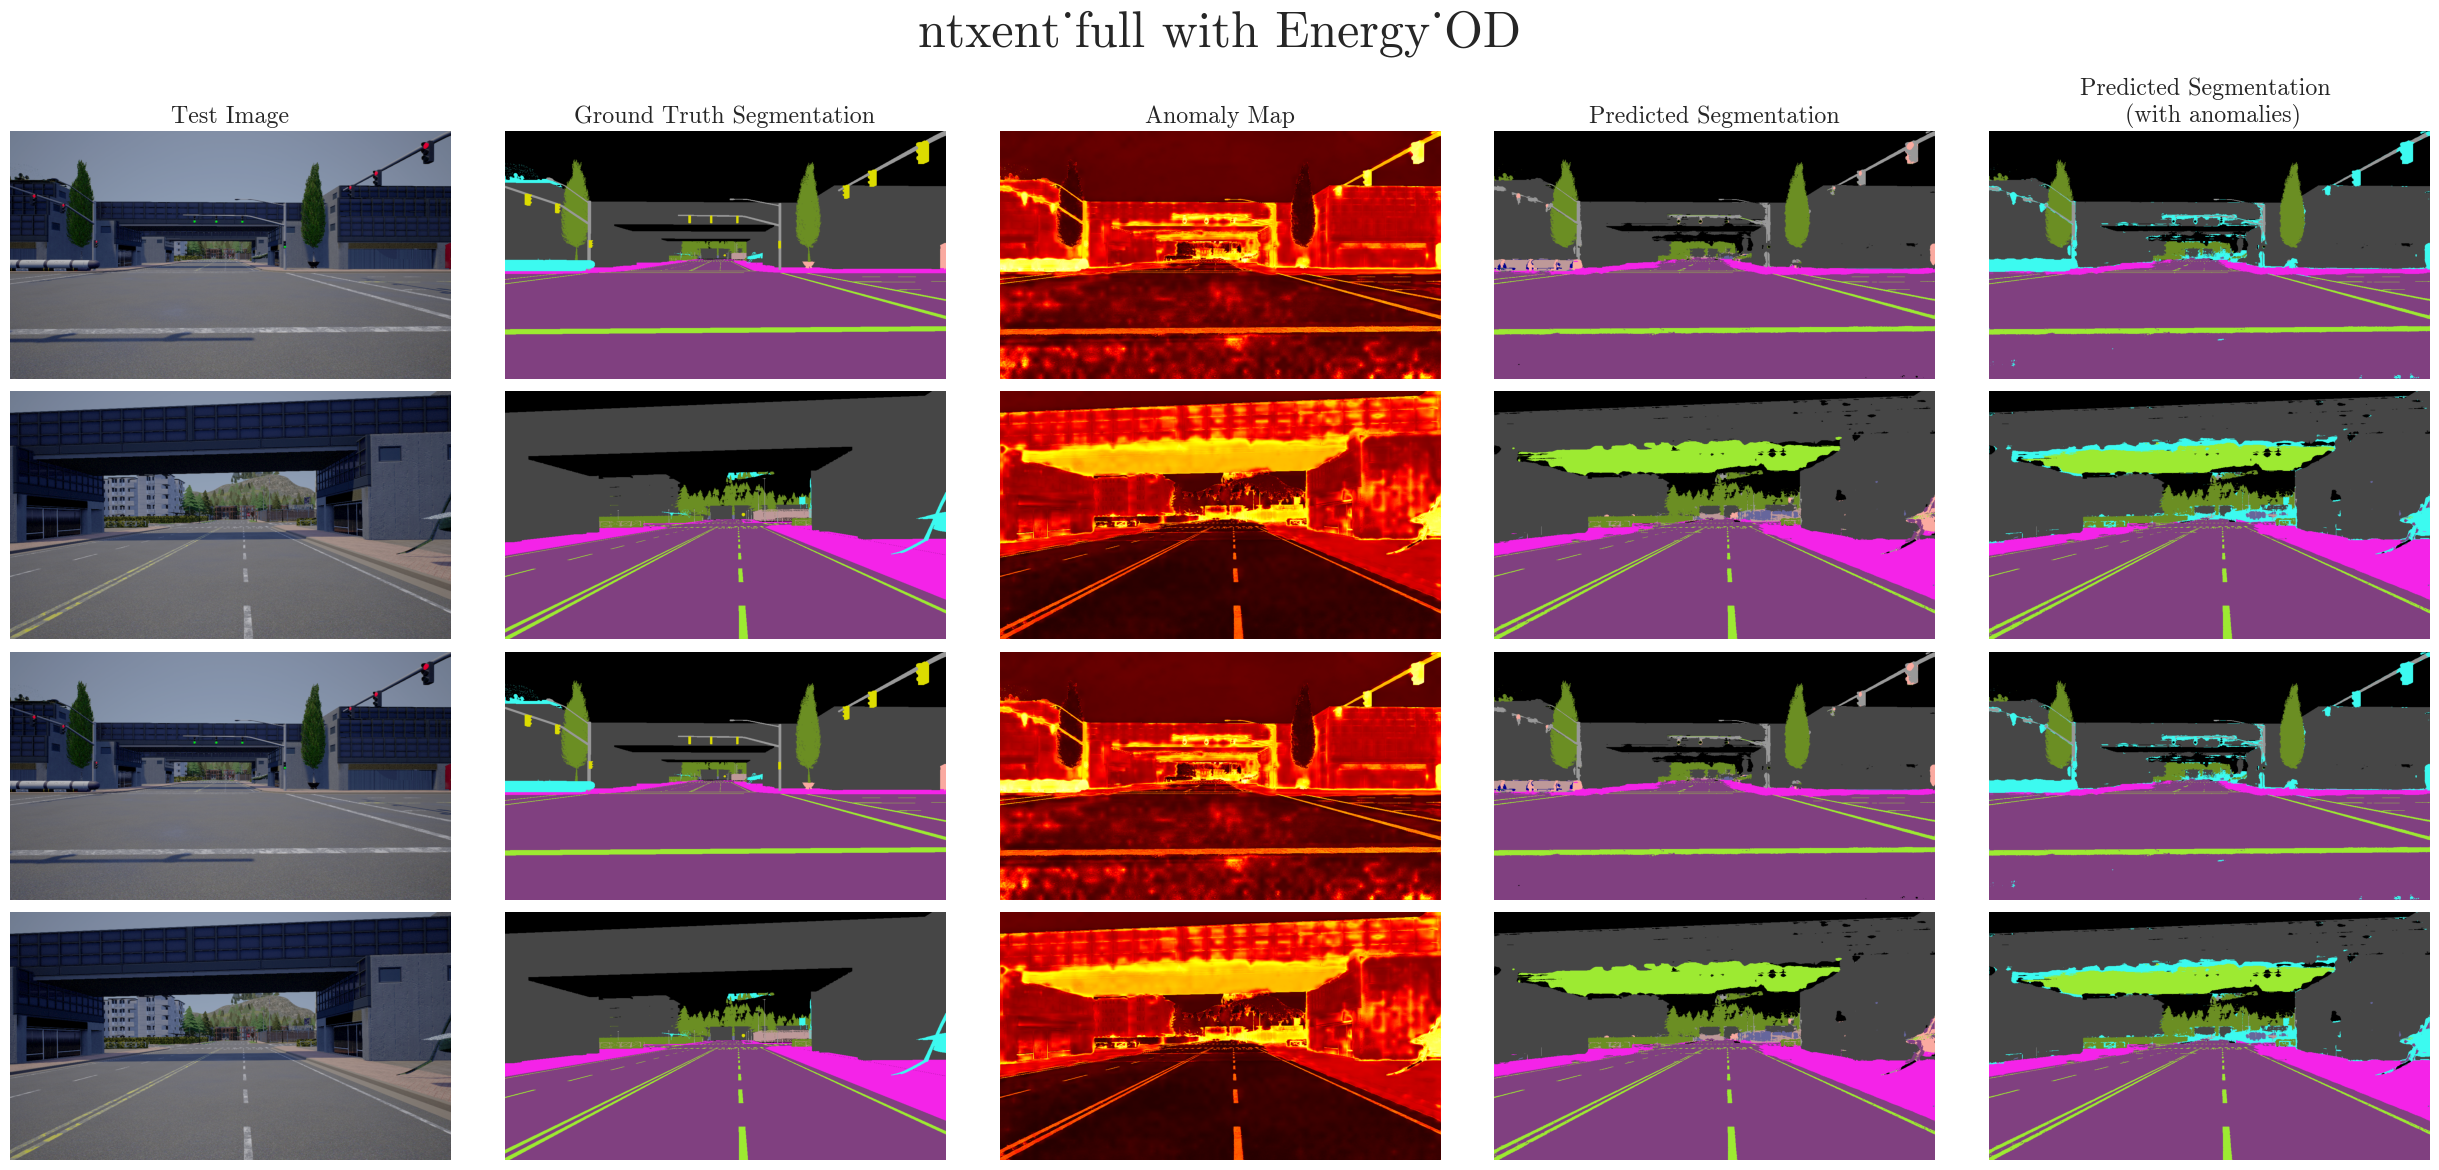

In [45]:
indices = INDICES + INDICES
plt.figure(figsize=(25, 3 * len(indices)))
# plt.subplots_adjust(top=1.5)
plt.suptitle(f"{model_name} with {detector_name}", fontsize=36)
for index, i in enumerate(indices):
    plt.subplot(len(indices), 5, index * 5 + 1)
    plt.imshow(de_normalize(test_images[i]).permute(1, 2, 0))
    plt.axis("off")
    if index == 0:
        plt.title("Test Image")

    plt.subplot(len(indices), 5, index * 5 + 2)
    plt.imshow(color(test_segmentations[i]))
    plt.axis("off")
    if index == 0:
        plt.title("Ground Truth Segmentation")

    plt.subplot(len(indices), 5, index * 5 + 3)
    plt.imshow(anomaly_maps[i].detach().squeeze(0).squeeze(0).cpu(), cmap="hot")
    plt.axis("off")
    if index == 0:
        plt.title("Anomaly Map")

    plt.subplot(len(indices), 5, index * 5 + 4)
    plt.imshow(color(pred_segmentations[i]))
    if index == 0:
        plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.subplot(len(indices), 5, index * 5 + 5)
    anoms = pred_segmentations[i].clone()
    anomaly_maps[i] = (anomaly_maps[i] - anomaly_maps[i].min()) / (anomaly_maps[i].max() - anomaly_maps[i].min())
    anoms[anomaly_maps[i] > 0.7] = 13
    plt.imshow(color(anoms))
    if index == 0:
        plt.title("Predicted Segmentation \n (with anomalies)")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Ablation Study

As seen in the previous section, removing the small CNN **MISSING** the performance of the model. This suggests that low-level features are __important for accurately segmenting both known and unknown classes__. Also, the choice of $\lambda_2 = 0$ (i.e., removing the metric learning loss) **MISSING** the performance, indicating that the metric learning component __helps the model learn a more discriminative feature space__.

# Conclusion

Is this needed????

---

# Discarded approaches

## Loss weighting
Since the two losses, $\mathcal{L}_{CE}$ and $\mathcal{L}_{\texttt{metric}}$, have different scales, I tried to weight them using [Uncertainty Weighting](https://arxiv.org/abs/1705.07115) and [Normalized Weighting](https://arxiv.org/abs/1711.02257v4). However, both methods did not improve the performance of the model, and the best performing method was using the two hyperparams $\lambda_1$ and $\lambda_2$.

## Autoencoder
I also tested an autoencoder approach, where the model is trained to reconstruct the input image. The idea is that the model will learn to reconstruct known classes well, but will struggle to reconstruct unknown classes, leading to higher reconstruction errors for anomalies. However, the resulting model were not able to achieve good reconstruction quality, hence reducing the effectiveness of this approach.